# Building a comic book writer AI agent

### Install required libraries

In [4]:
pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install -q langgraph-checkpoint-sqlite


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load Environment Variables

In [7]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

### Step1: Define the agent state

In [11]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated

model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

### Step2: Craft the Prompts

In [13]:
# Defining the planning prompt 
PLAN_PROMPT = '''
You are an expert comic book writer tasked with creating a high-level outline for a new comic book issue.

Develop a compelling outline for the user-provided theme or title.

Include details like:
*   Main characters and their motivations
*   Key plot points and conflicts
*   Setting and atmosphere
*   Potential twists or surprises
'''

# defining the prompt that will be used by the agent that's doing research after the planning step
# given a plan, it will generate some queries and pass them to Tavily
RESEARCH_PLAN_PROMPT = '''
You are a researcher assisting a comic book writer. Given the following comic book outline, generate a list of \
search queries to gather relevant information for inspiration and world-building. Only generate 3 queries max.
'''

# Defining the writer prompt
WRITER_PROMPT = '''
You are a comic book writer AI assistant tasked with crafting engaging and imaginative comic book scripts.

Generate the best script possible based on the user's request and the initial outline.

If the user provides critique, respond with a revised version of your previous attempts.

Utilize all the information below as needed:

------

{content}
'''

# Defining the reflection prompt
REFLECTION_PROMPT = '''
You are a comic book editor reviewing a script submission.

Generate a detailed critique and recommendations for the user's submission.

Provide specific feedback on elements like:
*   Plot coherence and pacing
*   Character development and dialogue
*   Originality and creativity
*   Overall impact and potential for success
'''

# Defining the research critique prompt
RESEARCH_CRITIQUE_PROMPT = ''''
You are a researcher assisting a comic book writer with revisions. 
Given the following critique of a comic book script, generate a list of search queries to gather relevant information for addressing the \
feedback. 
Only generate 3 queries max.
'''

from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]


# Importing and instantiating a tavily client
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


### Step 3: Implement the Agents

In [16]:
# Creating the planning node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

# Creating the reseach_plan_node
# It generates research queries based on a given task and retrieves relevant content using those queries
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    # content = state['content'] or [] # fix - change to this:
    content = state.get('content', [])
    
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}
# Creating the generation node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    
    response = model.invoke(messages)
     
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }
# Creating the reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}
# Creating the research critique node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {'content': content}

### Step 4: Construct the LangGraph

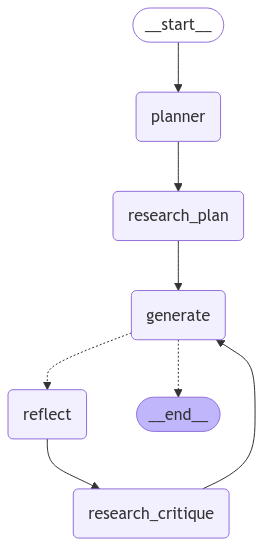

In [21]:
# Defining the conditional edge
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'
    
builder = StateGraph(AgentState)

# Adding nodes to the graph
builder.add_node('planner', plan_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_critique', research_critique_node)

# Setting the entry point of the state graph
builder.set_entry_point('planner')

# Adding the conditional edge
builder.add_conditional_edges(
    'generate', 
    should_continue, 
    {END: END, 'reflect': 'reflect'}
)

# Adding regular edges
builder.add_edge('planner', 'research_plan')
builder.add_edge('research_plan', 'generate')

builder.add_edge('reflect', 'research_critique')
builder.add_edge('research_critique', 'generate')

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')

graph = builder.compile(checkpointer=MemorySaver())

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Step 5: Run the Agentic App

In [24]:
thread = {'configurable': {'thread_id': '1'}}
task = 'The Rise of the Cybernetic Samurai'

prompt = {
    'task': task,
    'max_revisions': 3,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': '**Comic Book Issue Outline: "The Rise of the Cybernetic Samurai"**\n\n**Setting and Atmosphere:**\nThe story is set in a near-future Tokyo, where traditional Japanese culture collides with advanced technology. Neon lights illuminate ancient temples, and bustling streets are filled with both humans and cybernetic beings. The atmosphere is a blend of high-tech urban life and the serene beauty of nature, with cherry blossoms juxtaposed against towering skyscrapers. The city is rife with corruption, where mega-corporations control the government, and the underbelly of society is filled with rogue hackers and cybernetic warriors.\n\n**Main Characters:**\n\n1. **Kaito Tanaka (The Cybernetic Samurai)**: A skilled swordsman and former member of a prestigious samurai clan, Kaito has undergone cybernetic enhancements after a tragic incident left him near death. His motivation is to reclaim his family\'s honor and protect the innocent from the oppressive corporate regime.\n\

In [26]:
print(e['generate']['draft'])

**Comic Book Issue Script: "The Rise of the Cybernetic Samurai"**

**Page 1: Opening Scene**

*Panel 1:* A panoramic view of near-future Tokyo at dusk. Neon lights flicker against the backdrop of ancient temples, cherry blossoms swirling in the wind. The city is alive, but a sense of foreboding lingers.

*Caption:* "In a world where tradition meets technology, honor is a fleeting shadow..."

*Panel 2:* Close-up of Kaito Tanaka, clad in a sleek, cybernetic armor, his eyes reflecting the neon glow. He stands on a rooftop, gazing down at the bustling streets below.

*Kaito (thought bubble):* "What does it mean to be a samurai in a world like this?"

---

**Page 2: Inciting Incident**

*Panel 1:* A peaceful protest in the streets, filled with citizens holding signs against corporate oppression. Tension hangs in the air.

*Panel 2:* Suddenly, corporate enforcers arrive, armed and ready. The crowd panics.

*Panel 3:* Kaito watches from above, his expression a mix of anger and helplessness.

